# Resturant Review Sentiment - Transformer
### Matthew Newton
* Can a transformer model provide better results?
* Imported an existing LLM for review classification "huawei-noah/TinyBERT_General_4L_312D" for huggingface.
* Tune model on training data.
* The training data will be input into this model to predict the review scores.

In [38]:
import pandas as pd
import pickle
import numpy as np

import torch
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset, TensorDataset

from transformers import BertTokenizer, BertForSequenceClassification
from transformers import BertTokenizerFast, DistilBertTokenizerFast, DistilBertForSequenceClassification
from transformers import AdamW

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

import warnings
warnings.filterwarnings("ignore")

In [39]:
df_review = pd.read_pickle("./cleaned_data/reviews_cleaned_nltk.pickle")

In [40]:
# Split training data into train data, cross validation and test data
df_long = df_review
df_review = df_review.dropna()
df_review['text'] = df_review['title'] + " " + df_review['text']
df_review = df_review[:1000]
features = ['text']
#features = ['text', 'title', 'type', 'priceInterval', 'date', 'review_length', 'rest_rating']
X_train, X_cv, y_train, y_cv = train_test_split(df_review[features], df_review['rating'], test_size = 0.30, random_state = 0)
X_cv, X_test, y_cv, y_test = train_test_split(X_cv[features], y_cv, test_size = 0.50, random_state = 0)

In [41]:
y_train = np.array(y_train) - 1
y_cv = np.array(y_cv) - 1
y_test = np.array(y_test) - 1

In [42]:
# Load the tokenizer and model
tokenizer = BertTokenizerFast.from_pretrained('huawei-noah/TinyBERT_General_4L_312D')
model = BertForSequenceClassification.from_pretrained('huawei-noah/TinyBERT_General_4L_312D', num_labels=5)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at huawei-noah/TinyBERT_General_4L_312D and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 312, padding_idx=0)
      (position_embeddings): Embedding(512, 312)
      (token_type_embeddings): Embedding(2, 312)
      (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-3): 4 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=312, out_features=312, bias=True)
              (key): Linear(in_features=312, out_features=312, bias=True)
              (value): Linear(in_features=312, out_features=312, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=312, out_features=312, bias=True)
              (LayerNorm): LayerNorm((312,), eps=1e-1

In [43]:
# Tokenize the data
def tokenize_data(texts, labels=None, max_len=128):
    encodings = tokenizer(
        texts.tolist(), 
        truncation=True, 
        padding=True, 
        max_length=max_len, 
        return_tensors='pt'
    )
    
    input_ids = encodings['input_ids']
    attention_masks = encodings['attention_mask']

    if labels is not None:
        labels = torch.tensor(labels, dtype=torch.long)
        return input_ids, attention_masks, labels
    return input_ids, attention_masks

# Apply tokenization
train_inputs, train_masks, train_labels = tokenize_data(X_train['text'], y_train)
val_inputs, val_masks, val_labels = tokenize_data(X_cv['text'], y_cv)
test_inputs, test_masks = tokenize_data(X_test['text'])  # Test set doesn't have labels

In [44]:
# Create datasets
train_dataset = TensorDataset(train_inputs, train_masks, train_labels)
val_dataset = TensorDataset(val_inputs, val_masks, val_labels)

# Create dataloaders
batch_size = 16
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [45]:
# Define optimizer and loss function
optimizer = AdamW(model.parameters(), lr=2e-4)
criterion = nn.CrossEntropyLoss()

# Training function
def train_model(model, train_dataloader, val_dataloader, epochs=4):
    model.train()

    for epoch in range(epochs):
        total_train_loss = 0
        total_train_correct = 0
        for step, batch in enumerate(train_dataloader):
            input_ids, attention_masks, labels = tuple(b.to(device) for b in batch)
            
            # Forward pass
            outputs = model(input_ids, attention_mask=attention_masks)
            loss = criterion(outputs.logits, labels)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Accumulate training loss
            total_train_loss += loss.item()
            preds = torch.argmax(outputs.logits, dim=1)
            total_train_correct += torch.sum(preds == labels).item()

        # Evaluate after each epoch
        avg_train_loss = total_train_loss / len(train_dataloader)
        avg_train_acc = total_train_correct / len(train_dataset)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_acc:.4f}")
        evaluate_model(model, val_dataloader)

# Evaluation function
def evaluate_model(model, dataloader):
    model.eval()
    total_eval_loss = 0
    total_eval_correct = 0

    with torch.no_grad():
        for batch in dataloader:
            input_ids, attention_masks, labels = tuple(b.to(device) for b in batch)

            outputs = model(input_ids, attention_mask=attention_masks)
            loss = criterion(outputs.logits, labels)

            total_eval_loss += loss.item()
            preds = torch.argmax(outputs.logits, dim=1)
            total_eval_correct += torch.sum(preds == labels).item()

    avg_val_loss = total_eval_loss / len(dataloader)
    avg_val_acc = total_eval_correct / len(val_dataset)

    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Acc: {avg_val_acc:.4f}")


In [46]:
# Train the model
train_model(model, train_dataloader, val_dataloader, epochs=10)

Epoch 1/10, Train Loss: 1.2885, Train Acc: 0.4957
Validation Loss: 1.0448, Validation Acc: 0.5733
Epoch 2/10, Train Loss: 1.0004, Train Acc: 0.5786
Validation Loss: 1.0207, Validation Acc: 0.5933
Epoch 3/10, Train Loss: 0.8664, Train Acc: 0.6243
Validation Loss: 0.9067, Validation Acc: 0.6400
Epoch 4/10, Train Loss: 0.6802, Train Acc: 0.7143
Validation Loss: 1.1274, Validation Acc: 0.6133
Epoch 5/10, Train Loss: 0.4973, Train Acc: 0.8000
Validation Loss: 1.2625, Validation Acc: 0.6133
Epoch 6/10, Train Loss: 0.3598, Train Acc: 0.8486
Validation Loss: 1.1639, Validation Acc: 0.5867
Epoch 7/10, Train Loss: 0.2660, Train Acc: 0.9086
Validation Loss: 1.4524, Validation Acc: 0.5667
Epoch 8/10, Train Loss: 0.2270, Train Acc: 0.9186
Validation Loss: 1.3212, Validation Acc: 0.5800
Epoch 9/10, Train Loss: 0.1924, Train Acc: 0.9286
Validation Loss: 1.3498, Validation Acc: 0.6000
Epoch 10/10, Train Loss: 0.1233, Train Acc: 0.9600
Validation Loss: 1.3376, Validation Acc: 0.6467


In [47]:
def predict(model, dataloader):
    model.eval()
    predictions = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids, attention_masks = tuple(b.to(device) for b in batch)
            outputs = model(input_ids, attention_mask=attention_masks)
            preds = torch.argmax(outputs.logits, dim=1)
            predictions.extend(preds.cpu().numpy())

    return np.array(predictions)

# Predict on the test set
test_dataloader = DataLoader(TensorDataset(test_inputs, test_masks), batch_size=batch_size, shuffle=False)
test_predictions = predict(model, test_dataloader)

In [48]:
# Evaluation metrics
print("Accuracy:", accuracy_score(test_predictions, y_test))
print("\nClassification Report:\n", classification_report(test_predictions, y_test))
print("\nConfusion Matrix:\n", confusion_matrix(test_predictions, y_test))

Accuracy: 0.58

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.14      0.25      0.18         4
           2       0.35      0.40      0.38        15
           3       0.60      0.53      0.56        59
           4       0.71      0.68      0.70        72

    accuracy                           0.58       150
   macro avg       0.36      0.37      0.36       150
weighted avg       0.61      0.58      0.60       150


Confusion Matrix:
 [[ 0  0  0  0  0]
 [ 3  1  0  0  0]
 [ 2  5  6  1  1]
 [ 0  1  8 31 19]
 [ 0  0  3 20 49]]


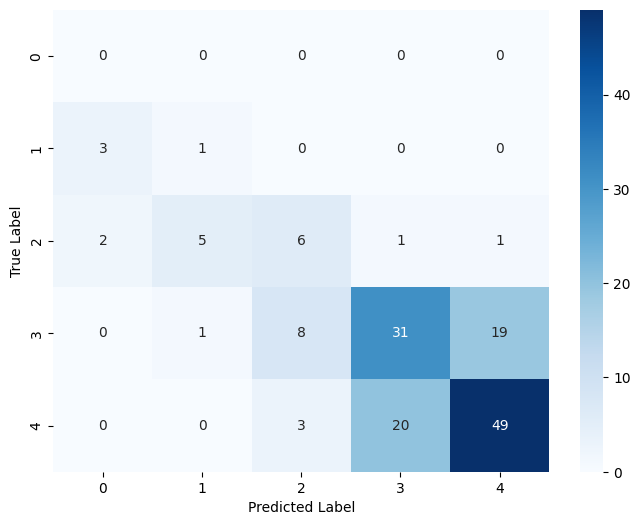

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(test_predictions, y_test), annot=True, fmt='d', cmap='Blues')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()